In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import aesara.tensor as at

In [2]:
az.style.use('arviz-white')

## N-Dimensional Gaussian mixture

In [3]:
n = 20

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
logdsigma = np.linalg.slogdet(sigma)[1]

w1 = 0.1
w2 = (1 - w1)

In [4]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([at.log(w1) + log_like1, at.log(w2) + log_like2])

In [5]:
with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   initval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))
    
    idata_smc = pm.sample_smc(5000)

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Sampling: [X]
Sampling: [X]
Sampling: [X]
Sampling: [X]


In [6]:
idata_smc.sample_stats._t_sampling

42.097777128219604

0.0943

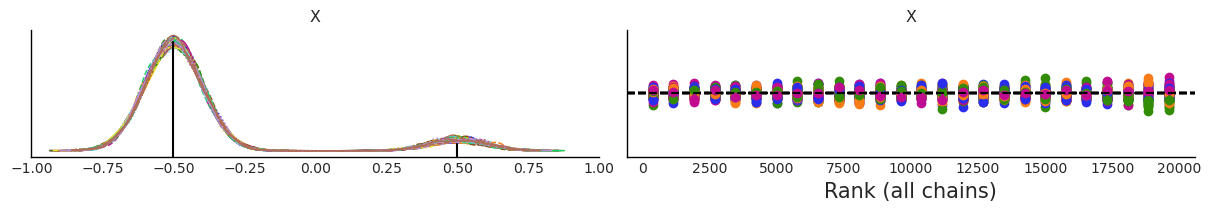

In [7]:
ax = az.plot_trace(idata_smc, compact=True, kind="rank_vlines")
ax[0, 0].axvline(-0.5, 0, .9, color="k")
ax[0, 0].axvline(0.5, 0, 0.1, color="k")
ax[0, 0].set_xlim(-1, 1)
np.mean(idata_smc.posterior["X"] > 0).item()

# Compute error score

In [8]:
# Wang bimodality index True Value
BI = abs(mu1 - mu2) * (w1*(1-w1))**0.5
posterior = idata_smc.posterior
error_score_list = []

for chain in posterior["chain"]:
    for dimension in posterior["X_dim_0"]:
        v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
        above_zero = v > 0
        below_zero = v < 0
        w1_ = np.mean(below_zero)
        if np.any(above_zero) and np.any(below_zero):
            BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w1_*(1-w1_))**0.5
        else:
            BI_ = 0
        error_score = (np.mean(((v-mu1[0]) * w1 + (v-mu2[0]) * w2))**2)**0.5 + abs(BI - BI_)
        error_score_list.append(error_score)

np.mean(error_score_list), np.std(error_score_list)

(0.013417250223991616, 0.01507614083697331)

## Coal mining disasters

For this model we may use NUTS as a "gold-standard"

In [9]:
disaster_data = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                           3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                           2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3,
                           0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1,
                           1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1,
                           0, 2, 3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2,
                           0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
                           1, 0, 1])

years = np.arange(1851, 1962)

In [10]:
with pm.Model() as mining:
    # Prior for the switch-point 
    sp = pm.DiscreteUniform('sp', lower=years.min(), upper=years.max())

    # Priors for the rate before (t_0) and after (t_1)
    t_0 = pm.Exponential('t_0', 1)
    t_1 = pm.Exponential('t_1', 1)

    # We assign the rate according to the sp,
    rate = pm.Deterministic("rate", pm.math.switch(sp >= years, t_0, t_1))

    # Likelihood
    acc = pm.Poisson('acc', rate, observed=disaster_data)
    
    # We compute the posterior
    idata = pm.sample_smc()

/home/osvaldo/proyectos/00_BM/pymc/pymc/model.py:1438: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Sampling: [acc_missing, sp, t_0, t_1]
Sampling: [acc_missing, sp, t_0, t_1]


Sampling: [acc_missing, sp, t_0, t_1]
Sampling: [acc_missing, sp, t_0, t_1]


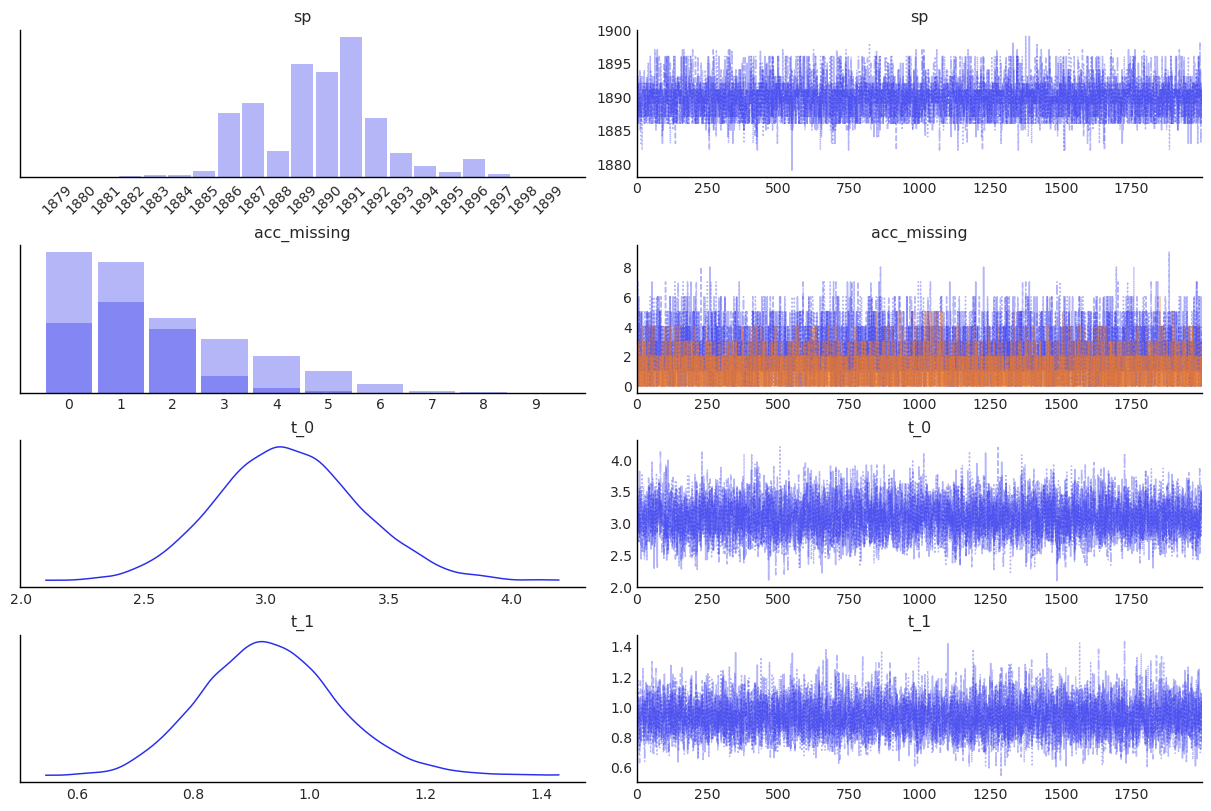

In [11]:
ax = az.plot_trace(idata, var_names=["~rate"], combined=True);
[ticks.set_rotation(45) for ticks in ax[0, 0].get_xticklabels()];

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [12]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [13]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sigma=5)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sigma=5)
    sigma_b = pm.HalfNormal('sigma_b', 5)
     
    a_offset = pm.Normal('a_offset', mu=0, sigma=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sigma=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
 
    eps = pm.HalfNormal('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal('radon_like', mu=radon_est, sigma=eps, observed=data.log_radon)
    idata_nuts = pm.sample(2000)
    idata_smc = pm.sample_smc(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a_offset, b_offset, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7112, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6591, but should be close to 0.8. Try to increase the number of tuning steps.
Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Sampling: [a_offset, b_offset, eps, mu_a, mu_b, sigma_a, sigma_b]
Sampling: [a_offset, b_offset, eps, mu_a, mu_b, sigma_a, sigma_b]
Sampling: [a_offset, b_offset, eps, mu_a, mu_b, sigma_a, sigma_b]
Sampling: [a_offset, b_offset, eps, mu_a, mu_b, sigma_a, sigma_b]
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [14]:
idata_smc.sample_stats._t_sampling

55.21448349952698

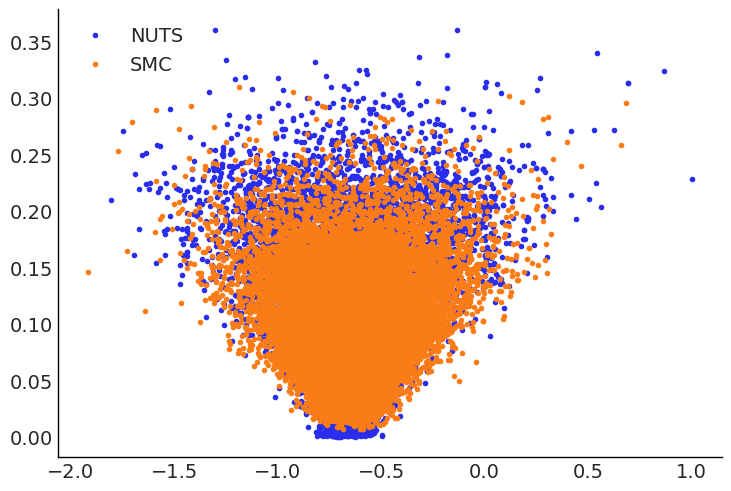

In [15]:
nuts_posterior = idata_nuts.posterior.stack(samples=("chain", "draw"))
smc_posterior = idata_smc.posterior.stack(samples=("chain", "draw"))
plt.plot(nuts_posterior["b"].isel(b_dim_0=75), nuts_posterior["sigma_b"], '.C0', label="NUTS")
plt.plot(smc_posterior["b"].isel(b_dim_0=75), smc_posterior["sigma_b"], '.C1', label="SMC")

plt.legend();